<a href="https://colab.research.google.com/github/tztechno/cc_archive/blob/main/AvatarArtist3_Triplane_Decomposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.



In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.


## **Step3**
# **AvatarArtist3: Triplane Decomposition**

https://kumapowerliu.github.io/AvatarArtist/

Step1: https://www.kaggle.com/code/stpeteishii/avatarartist1-2d-domain-transfer

Step2: https://www.kaggle.com/code/stpeteishii/avatarartist2-next3d-4d-gan-fine-tuning

Step3: https://www.kaggle.com/code/stpeteishii/avatarartist3-triplane-decomposition

Step4: https://www.kaggle.com/code/stpeteishii/avatarartist4-diffusion-transformer-dit-training

Step5: https://www.kaggle.com/code/stpeteishii/avatarartist5-avatar-generation-inference

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
gd_path='/content/drive/MyDrive/your_folder'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import userdata
hf_token0=userdata.get('secret_hf_token')

In [ ]:
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118
!pip install diffusers transformers accelerate
!pip install controlnet-aux opencv-python pillow
!pip install mediapipe==0.10.9

Looking in indexes: https://download.pytorch.org/whl/cu118
ERROR: Could not find a version that satisfies the requirement mediapipe==0.10.9 (from versions: 0.10.13, 0.10.14, 0.10.15, 0.10.18, 0.10.20, 0.10.21, 0.10.30, 0.10.31)
ERROR: No matching distribution found for mediapipe==0.10.9


In [ ]:
final_model_path =f'{gd_path}/next3d_checkpoints/final_model.pt'

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
from pathlib import Path
from typing import Dict, List, Optional, Tuple
from tqdm import tqdm
import pickle
import json


# ==================== Next3D Model Definitions (Duplicated from training script) ====================

class MappingNetwork(nn.Module):
    """StyleGAN2-style Mapping Network"""

    def __init__(self, z_dim: int = 512, w_dim: int = 512, num_layers: int = 8):
        super().__init__()
        layers = []
        for i in range(num_layers):
            in_dim = z_dim if i == 0 else w_dim
            layers.extend([
                nn.Linear(in_dim, w_dim),
                nn.LeakyReLU(0.2)
            ])
        self.net = nn.Sequential(*layers)

    def forward(self, z):
        return self.net(z)


class NoiseInjection(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        noise = torch.randn(x.shape[0], 1, x.shape[2], x.shape[3], device=x.device)
        return x + self.weight * noise


class StyleBlock(nn.Module):
    """StyleGAN2-style Block"""

    def __init__(self, in_ch, out_ch, w_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.style1 = nn.Linear(w_dim, in_ch)
        self.style2 = nn.Linear(w_dim, out_ch)
        self.noise1 = NoiseInjection()
        self.noise2 = NoiseInjection()
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x, w):
        # First conv + style modulation
        s1 = self.style1(w).unsqueeze(-1).unsqueeze(-1)
        x = self.conv1(x * s1)
        x = self.noise1(x)
        x = self.activation(x)

        # Second conv + style modulation
        s2 = self.style2(w).unsqueeze(-1).unsqueeze(-1)
        x = self.conv2(x * s2)
        x = self.noise2(x)
        x = self.activation(x)

        return x


class TriplaneBackbone(nn.Module):
    """Triplane Generation Backbone"""

    def __init__(self, w_dim: int, channels: int, resolution: int):
        super().__init__()
        self.w_dim = w_dim
        self.channels = channels
        self.resolution = resolution

        # StyleGAN2-like synthesis network
        self.const = nn.Parameter(torch.randn(1, channels, 4, 4))

        self.blocks = nn.ModuleList([
            StyleBlock(channels, channels, w_dim),
            StyleBlock(channels, channels, w_dim),
            StyleBlock(channels, channels, w_dim),
            StyleBlock(channels, channels, w_dim),
        ])

        # Output: 64x64 with correct channels for super-resolution
        self.to_features = nn.Conv2d(channels, channels, 1)

    def forward(self, w):
        B = w.shape[0]
        x = self.const.repeat(B, 1, 1, 1)

        for block in self.blocks:
            x = block(x, w)
            x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)

        # Final output: [B, channels, 64, 64]
        features = self.to_features(x)
        return features


class SuperResolutionModule(nn.Module):
    """Super-resolution module: 64x64 -> 512x512"""

    def __init__(self, in_channels, output_resolution=512):
        super().__init__()
        # 64x64 -> 512x512 requires 3 upsampling steps (2^3 = 8x)
        self.conv_blocks = nn.Sequential(
            # 64x64 -> 128x128
            nn.Conv2d(in_channels, 128, 3, padding=1),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),

            # 128x128 -> 256x256
            nn.Conv2d(128, 64, 3, padding=1),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),

            # 256x256 -> 512x512
            nn.Conv2d(64, 32, 3, padding=1),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),

            # Final conv to RGB
            nn.Conv2d(32, 3, 3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.conv_blocks(x)


class TriplaneGenerator(nn.Module):
    """Next3D Triplane Generator"""

    def __init__(
        self,
        z_dim: int = 512,
        w_dim: int = 512,
        triplane_channels: int = 96,
        triplane_resolution: int = 256,
        use_3dmm: bool = True,
        shape_dim: int = 80,
        exp_dim: int = 64
    ):
        super().__init__()
        self.z_dim = z_dim
        self.w_dim = w_dim
        self.use_3dmm = use_3dmm

        # Mapping Network (z -> w)
        self.mapping = MappingNetwork(z_dim, w_dim)

        # 3DMM Conditioning Module (Dynamic Component)
        if use_3dmm:
            self.shape_encoder = nn.Linear(shape_dim, w_dim)
            self.exp_encoder = nn.Linear(exp_dim, w_dim)
            self.condition_fusion = nn.Linear(w_dim * 3, w_dim)

        # Triplane generation network
        self.triplane_generator = TriplaneBackbone(
            w_dim=w_dim,
            channels=triplane_channels,
            resolution=triplane_resolution
        )

        # Super-resolution module (Low-res -> High-res)
        self.superres = SuperResolutionModule(
            triplane_channels,
            output_resolution=512
        )

    def forward(
        self,
        z: torch.Tensor,
        shape: Optional[torch.Tensor] = None,
        exp: Optional[torch.Tensor] = None,
        c: Optional[torch.Tensor] = None
    ):
        """
        Args:
            z: Latent code [B, z_dim]
            shape: 3DMM shape parameters [B, shape_dim]
            exp: 3DMM expression parameters [B, exp_dim]
            c: Camera parameters [B, 25]

        Returns:
            output: Generated image and triplanes
        """
        # Mapping network
        w = self.mapping(z)

        # 3DMM conditioning
        if self.use_3dmm and shape is not None and exp is not None:
            shape_feat = self.shape_encoder(shape)
            exp_feat = self.exp_encoder(exp)
            w_conditioned = self.condition_fusion(
                torch.cat([w, shape_feat, exp_feat], dim=1)
            )
        else:
            w_conditioned = w

        # Triplane generation
        triplane_features = self.triplane_generator(w_conditioned)

        # Rendering (Simplified: Actual version uses volume rendering)
        # Here we directly generate an image as a placeholder
        image = self.superres(triplane_features)

        return {
            'image': image,
            'triplane': triplane_features,  # For density regularization
            'w': w_conditioned
        }


# ==================== Triplane Decomposition Module ====================

class ParametricTriplaneDecomposer(nn.Module):
    """
    Decomposes Triplanes into Static and Dynamic components

    Static: Individual identity (shape, features)
    Dynamic: Changes dependent on expression and pose
    """

    def __init__(
        self,
        triplane_channels: int = 96,
        triplane_resolution: int = 256,
        static_ratio: float = 0.7
    ):
        super().__init__()
        self.channels = triplane_channels
        self.resolution = triplane_resolution

        # Channel split: Static vs Dynamic
        self.static_channels = int(triplane_channels * static_ratio)
        self.dynamic_channels = triplane_channels - self.static_channels

        print(f"Triplane Decomposition:")
        print(f"  Static: {self.static_channels}ch")
        print(f"  Dynamic: {self.dynamic_channels}ch")

    def decompose(
        self,
        triplane: torch.Tensor,
        pose: torch.Tensor,
        exp: torch.Tensor
    ) -> Dict[str, torch.Tensor]:
        """
        Decomposes triplane into Static/Dynamic components

        Args:
            triplane: [B, C, H, W] Triplane features
            pose: [B, 6] Pose parameters
            exp: [B, 64] Expression parameters

        Returns:
            {
                'static': [B, C_s, H, W],
                'dynamic': [B, C_d, H, W],
                'pose': [B, 6],
                'exp': [B, 64]
            }
        """
        # Split channels
        static = triplane[:, :self.static_channels]
        dynamic = triplane[:, self.static_channels:]

        return {
            'static': static,
            'dynamic': dynamic,
            'pose': pose,
            'exp': exp
        }

    def reconstruct(self, decomposed: Dict[str, torch.Tensor]) -> torch.Tensor:
        """
        Reconstructs triplane from Static/Dynamic components

        Args:
            decomposed: Output from decompose()

        Returns:
            triplane: [B, C, H, W]
        """
        return torch.cat([
            decomposed['static'],
            decomposed['dynamic']
        ], dim=1)


class TriplaneRenderer(nn.Module):
    """
    Renders an image from triplanes (Simplified version)
    Actual Next3D uses volume rendering
    """

    def __init__(self, triplane_channels: int = 96):
        super().__init__()

        # Rendering network (Simplified)
        self.decoder = nn.Sequential(
            nn.Conv2d(triplane_channels, 256, 3, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 3, 3, padding=1),
            nn.Tanh()
        )

    def forward(self, triplane: torch.Tensor) -> torch.Tensor:
        """
        Args:
            triplane: [B, C, H, W]

        Returns:
            image: [B, 3, H, W]
        """
        return self.decoder(triplane)


# ==================== Data Synthesizer ====================

class Next3DDataSynthesizer:
    """Synthesizes training data pairs from a Next3D model"""

    def __init__(
        self,
        generator_path: str,
        device: str = 'cuda',
        triplane_resolution: int = 256,
        use_3dmm: bool = True
    ):
        """
        Args:
            generator_path: Path to fine-tuned Next3D model
            device: Device (cuda/cpu)
            triplane_resolution: Triplane resolution
            use_3dmm: Use 3DMM parameters
        """
        self.device = device
        self.resolution = triplane_resolution
        self.use_3dmm = use_3dmm

        print("=" * 60)
        print("Next3D Data Synthesizer Initialization")
        print("=" * 60)

        # Load model
        print(f"\nLoading model: {generator_path}")
        self.load_generator(generator_path)

        # Triplane decomposer
        self.decomposer = ParametricTriplaneDecomposer(
            triplane_channels=96,
            triplane_resolution=triplane_resolution
        )

        # Renderer (Optional: for reconstruction tests)
        self.renderer = TriplaneRenderer(triplane_channels=96)

        print("\nInitialization Complete!")

    def load_generator(self, path: str):
        """Loads the Generator model"""
        checkpoint = torch.load(path, map_location=self.device)

        # Reconstruct Generator
        self.generator = TriplaneGenerator(
            z_dim=512,
            w_dim=512,
            triplane_channels=96,
            triplane_resolution=self.resolution,
            use_3dmm=self.use_3dmm
        ).to(self.device)

        # Load weights
        if 'generator' in checkpoint:
            state_dict = checkpoint['generator']
        else:
            state_dict = checkpoint

        # Adjust weight names for compatibility (if necessary)
        try:
            self.generator.load_state_dict(state_dict, strict=True)
            print("✓ Generator loaded successfully (strict mode)")
        except RuntimeError as e:
            print(f"⚠ Strict loading failed, trying flexible loading...")
            print(f"  Error: {e}")
            # Load flexibly if there are key mismatches
            self.generator.load_state_dict(state_dict, strict=False)
            print("✓ Generator loaded successfully (flexible mode)")

        self.generator.eval()

        # Display model info
        total_params = sum(p.numel() for p in self.generator.parameters())
        print(f"✓ Total parameters: {total_params:,}")

    def sample_3dmm_params(
        self,
        batch_size: int = 1,
        pose_range: float = 0.3,
        exp_strength: float = 1.0
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Samples 3DMM parameters

        Args:
            batch_size: Batch size
            pose_range: Random pose range (-pose_range, pose_range)
            exp_strength: Expression intensity

        Returns:
            shape: [B, 80] Shape parameters
            exp: [B, 64] Expression parameters
            pose: [B, 6] Pose parameters (yaw, pitch, roll, tx, ty, tz)
        """
        # Shape: Values close to neutral
        shape = torch.randn(batch_size, 80, device=self.device) * 0.5

        # Expression: Random expressions
        exp = torch.randn(batch_size, 64, device=self.device) * exp_strength

        # Pose: yaw, pitch, roll, translation
        pose = torch.rand(batch_size, 6, device=self.device) * 2 * pose_range - pose_range

        return shape, exp, pose

    def generate_sample(
        self,
        z: Optional[torch.Tensor] = None,
        shape: Optional[torch.Tensor] = None,
        exp: Optional[torch.Tensor] = None,
        pose: Optional[torch.Tensor] = None
    ) -> Dict[str, torch.Tensor]:
        """
        Generates a single sample

        Args:
            z: Latent code [B, 512]
            shape: Shape parameters [B, 80]
            exp: Expression parameters [B, 64]
            pose: Pose parameters [B, 6]

        Returns:
            {
                'image': [B, 3, H, W],
                'triplane_static': [B, C_s, H, W],
                'triplane_dynamic': [B, C_d, H, W],
                'z': [B, 512],
                'shape': [B, 80],
                'exp': [B, 64],
                'pose': [B, 6]
            }
        """
        with torch.no_grad():
            # Generate default parameters
            if z is None:
                z = torch.randn(1, 512, device=self.device)

            if self.use_3dmm:
                if shape is None or exp is None or pose is None:
                    shape, exp, pose = self.sample_3dmm_params(z.shape[0])
            else:
                shape, exp, pose = None, None, None

            # Execute Generator
            output = self.generator(z, shape, exp)

            image = output['image']
            triplane = output['triplane']

            # Decompose Triplane
            if self.use_3dmm:
                decomposed = self.decomposer.decompose(triplane, pose, exp)
            else:
                # If no 3DMM, treat everything as static
                decomposed = {
                    'static': triplane,
                    'dynamic': torch.zeros_like(triplane[:, :10]),  # Dummy
                    'pose': torch.zeros(z.shape[0], 6, device=self.device),
                    'exp': torch.zeros(z.shape[0], 64, device=self.device)
                }

            return {
                'image': image,
                'triplane_static': decomposed['static'],
                'triplane_dynamic': decomposed['dynamic'],
                'z': z,
                'shape': shape if shape is not None else torch.zeros(z.shape[0], 80),
                'exp': exp if exp is not None else torch.zeros(z.shape[0], 64),
                'pose': pose if pose is not None else torch.zeros(z.shape[0], 6)
            }

    def synthesize_dataset(
        self,
        num_samples: int,
        output_dir: str,
        batch_size: int = 8,
        save_images: bool = True,
        save_format: str = 'npz'  # 'npz' or 'pth'
    ):
        """
        Synthesizes a large volume of data pairs

        Args:
            num_samples: Number of samples to generate
            output_dir: Output directory
            batch_size: Batch size
            save_images: Whether to save images as well
            save_format: 'npz' or 'pth'
        """
        os.makedirs(output_dir, exist_ok=True)

        if save_images:
            img_dir = os.path.join(output_dir, 'images')
            os.makedirs(img_dir, exist_ok=True)

        triplanes_dir = os.path.join(output_dir, 'triplanes')
        os.makedirs(triplanes_dir, exist_ok=True)

        print(f"\n{'='*60}")
        print(f"Dataset Synthesis Starting: {num_samples} samples")
        print(f"Output Path: {output_dir}")
        print(f"Format: {save_format}")
        print(f"{'='*60}\n")

        num_batches = (num_samples + batch_size - 1) // batch_size
        sample_idx = 0

        metadata = []

        for batch_idx in tqdm(range(num_batches), desc="Synthesizing"):
            current_batch_size = min(batch_size, num_samples - sample_idx)

            # Batch generation
            z = torch.randn(current_batch_size, 512, device=self.device)

            if self.use_3dmm:
                shape, exp, pose = self.sample_3dmm_params(current_batch_size)
            else:
                shape, exp, pose = None, None, None

            # Sample generation
            samples = self.generate_sample(z, shape, exp, pose)

            # Save each sample
            for i in range(current_batch_size):
                idx = sample_idx + i

                # Parametric Triplane data
                triplane_data = {
                    'static': samples['triplane_static'][i].cpu().numpy(),
                    'dynamic': samples['triplane_dynamic'][i].cpu().numpy(),
                    'z': samples['z'][i].cpu().numpy(),
                    'shape': samples['shape'][i].cpu().numpy(),
                    'exp': samples['exp'][i].cpu().numpy(),
                    'pose': samples['pose'][i].cpu().numpy(),
                }

                # Save triplane
                triplane_path = os.path.join(
                    triplanes_dir,
                    f'triplane_{idx:06d}.{save_format}'
                )

                if save_format == 'npz':
                    np.savez_compressed(triplane_path, **triplane_data)
                elif save_format == 'pth':
                    torch.save({
                        k: torch.from_numpy(v) for k, v in triplane_data.items()
                    }, triplane_path)

                # Save image
                if save_images:
                    image = samples['image'][i]
                    image = (image.cpu().permute(1, 2, 0).numpy() + 1) / 2 * 255
                    image = image.clip(0, 255).astype(np.uint8)

                    img_path = os.path.join(img_dir, f'image_{idx:06d}.png')
                    Image.fromarray(image).save(img_path)

                # Metadata
                metadata.append({
                    'index': idx,
                    'triplane_path': triplane_path,
                    'image_path': os.path.join(img_dir, f'image_{idx:06d}.png') if save_images else None,
                    'static_shape': triplane_data['static'].shape,
                    'dynamic_shape': triplane_data['dynamic'].shape,
                })

            sample_idx += current_batch_size

        # Save metadata
        metadata_path = os.path.join(output_dir, 'metadata.json')
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2)

        # Save dataset info
        info = {
            'num_samples': num_samples,
            'triplane_resolution': self.resolution,
            'static_channels': self.decomposer.static_channels,
            'dynamic_channels': self.decomposer.dynamic_channels,
            'use_3dmm': self.use_3dmm,
            'format': save_format
        }

        info_path = os.path.join(output_dir, 'dataset_info.json')
        with open(info_path, 'w') as f:
            json.dump(info, f, indent=2)

        print(f"\n{'='*60}")
        print("Dataset Synthesis Complete!")
        print(f"{'='*60}")
        print(f"Generated Samples: {num_samples}")
        print(f"Triplanes: {triplanes_dir}")
        if save_images:
            print(f"Images: {img_dir}")
        print(f"Metadata: {metadata_path}")
        print(f"Dataset Info: {info_path}")
        print(f"{'='*60}\n")


# ==================== Data Loader (For Verification) ====================

class TriplaneDataset(torch.utils.data.Dataset):
    """Synthesized Triplane Dataset"""

    def __init__(self, data_dir: str, load_images: bool = True):
        """
        Args:
            data_dir: Dataset directory
            load_images: Whether to load images
        """
        self.data_dir = Path(data_dir)
        self.load_images = load_images

        # Load metadata
        with open(self.data_dir / 'metadata.json', 'r') as f:
            self.metadata = json.load(f)

        # Dataset info
        with open(self.data_dir / 'dataset_info.json', 'r') as f:
            self.info = json.load(f)

        print(f"Dataset loaded: {len(self.metadata)} samples")
        print(f"Info: {self.info}")

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        meta = self.metadata[idx]

        # Load triplane
        triplane_path = meta['triplane_path']

        if triplane_path.endswith('.npz'):
            data = np.load(triplane_path)
            triplane_data = {
                k: torch.from_numpy(data[k]) for k in data.keys()
            }
        else:  # .pth
            triplane_data = torch.load(triplane_path)

        result = {
            'static': triplane_data['static'],
            'dynamic': triplane_data['dynamic'],
            'z': triplane_data['z'],
            'shape': triplane_data['shape'],
            'exp': triplane_data['exp'],
            'pose': triplane_data['pose'],
        }

        # Load image
        if self.load_images and meta['image_path']:
            image = Image.open(meta['image_path'])
            image = torch.from_numpy(np.array(image)).permute(2, 0, 1).float() / 127.5 - 1
            result['image'] = image

        return result


# ==================== Main Execution ====================

def main():
    """Execute Data Synthesis"""

    # ========== Path Settings for Kaggle Environment ==========

    # Option 1: Load directly from Kaggle Dataset (Recommended)
    GENERATOR_PATH = f"{gd_path}/next3d_checkpoints/final_model.pt"

    # Option 2: For Local Environment
    # GENERATOR_PATH = "./next3d_checkpoints/final_model.pt"

    # Verify path existence
    if not os.path.exists(GENERATOR_PATH):
        print(f"❌ Model file not found: {GENERATOR_PATH}")
        print("\nSearching for available models...")

        # Search Kaggle input directory
        kaggle_input = "/kaggle/input"
        if os.path.exists(kaggle_input):
            for dataset in os.listdir(kaggle_input):
                dataset_path = os.path.join(kaggle_input, dataset)
                print(f"\n📁 Dataset: {dataset}")

                # Recursively search for .pt files
                for root, dirs, files in os.walk(dataset_path):
                    for file in files:
                        if file.endswith('.pt'):
                            full_path = os.path.join(root, file)
                            size_mb = os.path.getsize(full_path) / (1024 * 1024)
                            print(f"  ✓ {full_path} ({size_mb:.1f} MB)")

        print("\nPlease select a model path from the list above.")
        return

    print(f"✓ Model found: {GENERATOR_PATH}")

    # ========== Output Settings ==========

    OUTPUT_DIR = "./dit_training_data"  # Kaggle working directory

    NUM_SAMPLES = 100  # Small amount for testing (Production: 10000)
    BATCH_SIZE = 8
    SAVE_IMAGES = True
    SAVE_FORMAT = 'npz'

    TRIPLANE_RESOLUTION = 256
    USE_3DMM = True

    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Initialize Data Synthesizer
    try:
        synthesizer = Next3DDataSynthesizer(
            generator_path=GENERATOR_PATH,
            device=DEVICE,
            triplane_resolution=TRIPLANE_RESOLUTION,
            use_3dmm=USE_3DMM
        )
    except Exception as e:
        print(f"\n❌ Initialization failed: {e}")
        import traceback
        traceback.print_exc()
        return

    # Synthesize Dataset
    synthesizer.synthesize_dataset(
        num_samples=NUM_SAMPLES,
        output_dir=OUTPUT_DIR,
        batch_size=BATCH_SIZE,
        save_images=SAVE_IMAGES,
        save_format=SAVE_FORMAT
    )

    # Verification: Data Loader Test
    print("\n" + "="*60)
    print("Dataset Verification")
    print("="*60)

    dataset = TriplaneDataset(OUTPUT_DIR, load_images=SAVE_IMAGES)

    # Check sample
    sample = dataset[0]
    print("\nSample Check:")
    for key, value in sample.items():
        if isinstance(value, torch.Tensor):
            print(f"  {key}: {value.shape}")

    print("\n✓ Dataset Synthesis and Verification Complete!")


if __name__ == "__main__":
    main()

✓ Model found: /content/drive/MyDrive/your_folder/next3d_checkpoints/final_model.pt
Next3D Data Synthesizer Initialization

Loading model: /content/drive/MyDrive/your_folder/next3d_checkpoints/final_model.pt
⚠ Strict loading failed, trying flexible loading...
  Error: Error(s) in loading state_dict for TriplaneGenerator:
	Missing key(s) in state_dict: "shape_encoder.weight", "shape_encoder.bias", "exp_encoder.weight", "exp_encoder.bias", "condition_fusion.weight", "condition_fusion.bias". 
✓ Generator loaded successfully (flexible mode)
✓ Total parameters: 4,235,947
Triplane Decomposition:
  Static: 67ch
  Dynamic: 29ch

Initialization Complete!

Dataset Synthesis Starting: 100 samples
Output Path: ./dit_training_data
Format: npz



Synthesizing:   0%|          | 0/13 [00:00<?, ?it/s]/tmp/ipython-input-1761350586.py:589: RuntimeWarning: invalid value encountered in cast
  image = image.clip(0, 255).astype(np.uint8)
Synthesizing: 100%|██████████| 13/13 [00:05<00:00,  2.17it/s]



Dataset Synthesis Complete!
Generated Samples: 100
Triplanes: ./dit_training_data/triplanes
Images: ./dit_training_data/images
Metadata: ./dit_training_data/metadata.json
Dataset Info: ./dit_training_data/dataset_info.json


Dataset Verification
Dataset loaded: 100 samples
Info: {'num_samples': 100, 'triplane_resolution': 256, 'static_channels': 67, 'dynamic_channels': 29, 'use_3dmm': True, 'format': 'npz'}

Sample Check:
  static: torch.Size([67, 64, 64])
  dynamic: torch.Size([29, 64, 64])
  z: torch.Size([512])
  shape: torch.Size([80])
  exp: torch.Size([64])
  pose: torch.Size([6])
  image: torch.Size([3, 512, 512])

✓ Dataset Synthesis and Verification Complete!


In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def show_image(image_dir):
    image_paths = [
        os.path.join(image_dir, f)
        for f in sorted(os.listdir(image_dir))
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ][:6]
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()
    for ax, img_path in zip(axes, image_paths):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(os.path.basename(img_path), fontsize=9)
    for ax in axes[len(image_paths):]:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

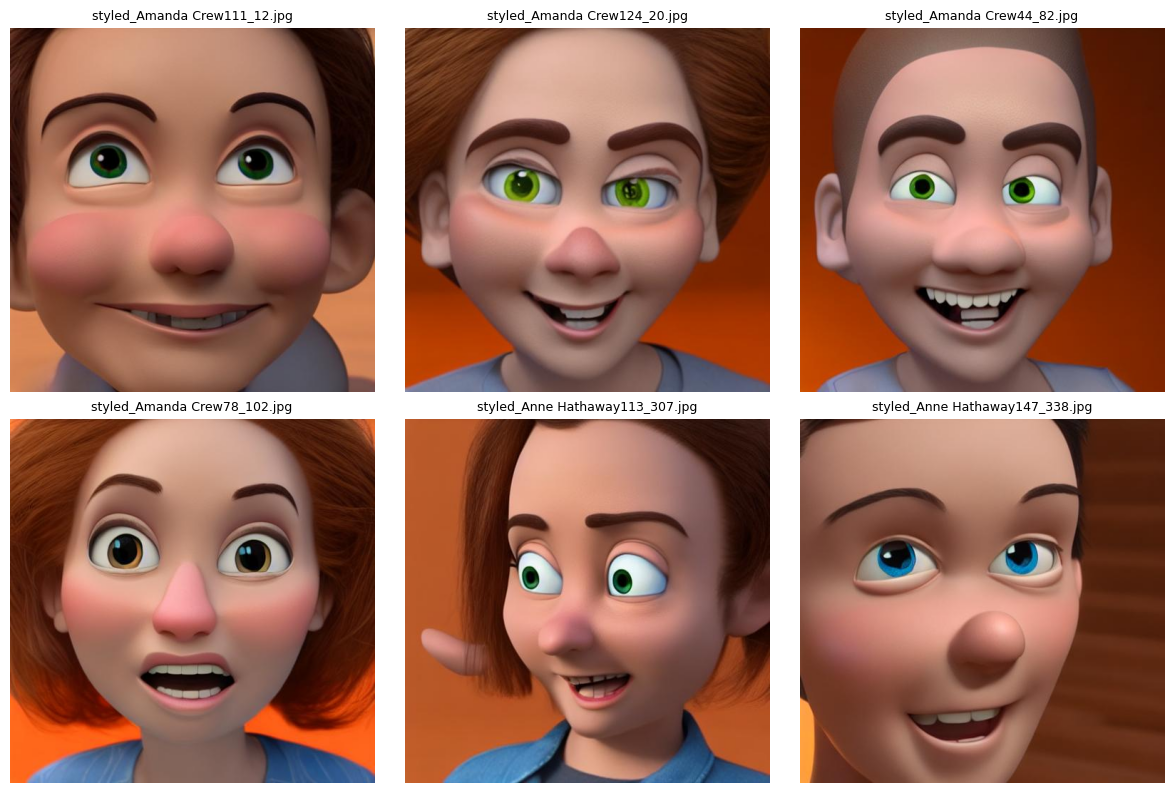

In [ ]:
show_image(f'{gd_path}/output_styled')